# Sales Prediction for Time Series Data

The goal of the project is to predict total sales for every product and store given a time-series data for a Russian software firm.  The competition and data is hosted on [Kaggle](https://www.kaggle.com/c/competitive-data-science-final-project).  Daily historical data is provided from January 2013 to October 2015.  The objective is to forecast the number of items sold for each of the item and shop combination for November 2015.  Daily data will have to aggregated into monthly data in order to make the predictions.
<br>
<br>
This notebook will load, clean, and explore the data.  The focus will be to understand where is the source of revenue for the firm, pricing, seasonality, products, and product categories.  

## Part 1: Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

Load helper fuctions

In [2]:
# %load helperFunctions.py
def show_info(dfList):
    '''print out information for a list of dataframes
    Argument: list of dataframe names
    Return: none
    '''
    for df in dfList:
        name = df.name
        print(name)
        print(df.head())
        
        print("------Description of Dataset -------" )
        print(df.describe())

        print("------Description of Dtypes --------" )
        print(df.dtypes)

        print("------Grouping by Dtypes --------" )
        print(df.columns.to_series().groupby(df.dtypes).groups)               # group by data types

        print("------count of unique values -------" )
        print(df.nunique())

        print("------count of np.nan -------" )
        print(df.isnull().sum())

        print("------zero variance numeric columns -------" )
        print(df.std()[df.std() == 0].index.values)
    
    return

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# column comparison
def col_comparison(df1, df2):
    '''
    compare two dataframes to see which columns are in both set, 
    in set1 only, and in set2 only
    arguments: df1, df2
    returns: samecols, df1only, df2only
    '''
    df1Cols = set(list(df1.columns.values))
    df2Cols = set(list(df2.columns.values))
    samecols = list(df1Cols.intersection(df2Cols))
    df1only = list(df1Cols & set(df1Cols ^ df2Cols))
    df2only = list(df2Cols & set(df1Cols ^ df2Cols))    
    df1name =[x for x in globals() if globals()[x] is df1][0]
    df2name =[x for x in globals() if globals()[x] is df2][0]    
    print('------ columns in both sets -----')
    print(samecols)
    print('')
    print('------ columns in %s only ----- ' % (df1name))
    print(df1only)
    print('')
    print('------ columns in %s only ----- ' % (df2name))
    print(df2only)
    
    return samecols, df1only, df2only
  

# define columns to add drop so train and test set matches
def make_cols_match(train, test, y_name):
    '''define columns to add drop so two datasets matches
    Arguments: train, test, y_name (dataframe 1, dataframe 2, output variable y in quotes)
    Returns: train, test
    '''
    print("---columns comparsion prior to change---")
    samecols, df1only, df2only = col_comparison(train, test)
    train_y = train[y_name]

    # remove columns only in train
    train = remove_columns(train, df1only)
    
    # remove columns only in test
    test = remove_columns(test, df2only)
    
    # append y_name to test and train
    train[y_name] = train_y
    test[y_name] = '0'

    
    return train, test

# show near-zero variance numeric columns
def nearZeroCols(df, threshold):
    '''show near-zero variance numeric columns <= to a threshold
    Arguments: df, threshold
    Returns: array of column names<= threshold
    '''
    return df.std()[df.std() <= threshold].index.values

# change data type
def cast_dtype(df, cols, dtype):
    ''' 
    change datatype of dataframe given column names
    Arguments: df: dataframe, cols: list of column names [], dtype: data type to cast to i.e.: 'int64', 'float64', 'str'
    Returns: dataframe
    '''
    df[cols] = df[cols].astype(dtype)
    
    return df  


def cast_datetime(df, cols):
    '''
    change datatype of dataframe to datetime given column names
    Arguments: df: dataframe, cols: column names in [' ', ' ']
    Returns: dataframe
    '''
    df.loc[:, cols] = df.loc[:, cols].apply(pd.to_datetime, errors='coerce')
    
    return df
 

# text processing
def process_text(text):
    '''
    perform a variety of transformations to text
    Argument: text
    Returns: text
    '''
    text = text.replace(r'.0', '')                  # remove .0 from the end of strings
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    text = text.lstrip('0')                         # strip leading 0
    text = ' '.join(text.split())                   # strip multiple whitespaces into 1
    text = text.strip()                             # strip whitespace
    text = text.lower()                             # convert to lower case
    
    return text

def textProcessing(df, cols):
    '''
    apply transformation of text to specified columns in a dataframe using function 'process_text'
    Arguments: dataframe, list of column names to transform
    Returns: dataframe'''
    
    if cols is None: 
        stringCols = df.loc[:, df.dtypes == object].columns
        dateTimeCols = df.select_dtypes(include=['datetime64']).columns
        cols = list(set(stringCols)-set(dateTimeCols))
    
    df.loc[:, cols] = df.loc[:, cols].applymap(lambda x: process_text(x))
    
    return df

# remove selected columns
def remove_columns(df, cols):
    ''' remove list of columns given a dataframe.  Error will not rise if column names are not in the dataframe
    Arguments: dataframe, list of column names
    Returns: dataframe'''
    
    cols = list(set(cols).intersection(df.columns))  # to avoid error, delete the named columns in dataframe's columns
    df = df.drop(cols, axis = 1)
    return df

# keep columns that are in both sets only
def keep_columns_in_both_sets(df1, df2):
    ''' given two dataframes, only keep columns that are in both dataframes
    Arguments: dataframe1, dataframe2
    Returns: dataframe1, dataframe2 '''
    
    cols = list(set(list(df1.columns.values)).intersection(list(df2.columns.values)))
    df1 = df1.loc[:,cols]
    df2 = df2.loc[:,cols]
    return df1, df2

# check for common form to signify missing observations, i.e. "0" or "nan" or "blank"
def missing_obs_count_by_column(df, cols, stringlist):
    ''' count the number of observations per columns (only string columns) in a dataframe
    given a list of values to match to 
    
    Arguments: dataframe, columns to search, strings to match
    Returns: print out report'''
    
    if stringlist is None:    
        stringlist = ['0', 'nan', '', 'missing', 'none', 'na']
    
    if cols is None:
        stringCols = df.loc[:, df.dtypes == object].columns
        dateTimeCols = df.select_dtypes(include=['datetime64']).columns
        cols = list(set(stringCols)-set(dateTimeCols))

    for string in stringlist:
        print('-----' + string + '------')
        print(np.sum(df.loc[:, cols].apply(lambda x: x == string)))
    return 


# replace strings
def replaceStrings(df, cols, pattern, replaceTo):
    ''' given a datframe and columns, replace the values of the observations given a pattern to match, and value to replace to
    Arguments: dataframe, columns, pattern to match, value to replace to
    Retruns: dataframe
    '''
    for col in cols:
        #df.loc[col] = df.loc[col].replace(pattern, replaceTo)
        df[col] = df[col].replace(pattern, replaceTo)
    return df


# drop near-zero variance numeric columns
def drop_features_based_on_std_threshold(df, threshold):
    '''given a dataframe, and threshold, drop columns with standard deviations
    that are under or equal to the threshold
    Arguments: dataframe, threshold
    Returns: dataframe '''
    
    uint8Cols = df.loc[:, df.dtypes == 'uint8'].columns
    float64Cols = df.loc[:, df.dtypes == 'float64'].columns
    cols = uint8Cols.append(float64Cols)
    
    stdCalc = df.loc[:,cols].apply(lambda x: np.std(x))
    sparseFeatures = stdCalc[stdCalc <= threshold].index
    
    df = df.drop(sparseFeatures, axis = 1)
    return df
    
    # This implementation is very slow
    #df = df.drop(df.std()[df.std() <= threshold].index.values, axis=1)
    #return df


# show uint8 columns with less than a threshold
def show_features_fewer_than_count(df, threshold):
    '''
    show uint8 columns with less than a threshold
    given a dataframe, filter columns that are uin8 (dummy variables)
    return series showing features with counts fewer than the threshold
    Arguments: dataframe, threshold for filtering count
    Return: a filtered named series with counts of none-zeros
    '''
    
    uint8Cols = df.loc[:, df.dtypes == 'uint8'].columns
    numCount = df.loc[:,uint8Cols].apply(lambda x: np.sum(x))
    sparseFeatures = numCount[numCount <= threshold]
    
    return sparseFeatures

# remove uint8 columns with less than a threshold
def remove_features_fewer_than_count(df, threshold):
    '''
    remove uint8 columns with less than a threshold
    given a dataframe, filter columns that are uin8 (dummy variables)
    delete sparse features from dataframe
    Arguments: dataframe, threshold for filtering count
    Return: dataframe
    '''
    uint8Cols = df.loc[:, df.dtypes == 'uint8'].columns
    numCount = df.loc[:,uint8Cols].apply(lambda x: np.sum(x))
    sparseFeatures = numCount[numCount <= threshold].index
    
    df = df.drop(sparseFeatures, axis = 1)
    return df


### Import data and merge datasets

In [3]:
DATA_FOLDER = '../data'
sales_train = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
sales_test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
shops = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
items = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_cats = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
sampleSubmission = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv.gz'))

sales_train.name = 'sales_train'
sales_test.name = 'sales_test'
shops.name = 'shops'
items.name = 'items'
item_cats.name = 'item_cats'

#### First Look at the data

In [4]:
dflist = [sales_train, sales_test, shops, items, item_cats]
#show_info(dflist)
print('training set: ', sales_train.shape)
print('test set: ', sales_test.shape)
print('num of shops: ', shops.shape)
print('num of items: ',items.shape)
print('num of item categories: ',item_cats.shape)

training set:  (2935849, 6)
test set:  (214200, 3)
num of shops:  (60, 2)
num of items:  (22170, 3)
num of item categories:  (84, 2)


In [5]:
print(sales_train.columns)
print(shops.columns)
print(items.columns)
print(item_cats.columns)

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')
Index(['shop_name', 'shop_id'], dtype='object')
Index(['item_name', 'item_id', 'item_category_id'], dtype='object')
Index(['item_category_name', 'item_category_id'], dtype='object')


In [6]:
print('num of items only in test set: ',len(set(list(sales_test.item_id.unique())) - set(list(sales_train.item_id.unique()))))
print('num of items only in training set: ',len(set(list(sales_train.item_id.unique())) - set(list(sales_test.item_id.unique()))))
print('num of items in both sets: ', len(set(list(sales_train.item_id.unique())).intersection(set(list(sales_test.item_id.unique())))))
print('num of shops only in test set: ',len(set(list(sales_test.shop_id.unique())) - set(list(sales_train.shop_id.unique()))))

num of items only in test set:  363
num of items only in training set:  17070
num of items in both sets:  4737
num of shops only in test set:  0


#### Combine sales and test set for ease of pre-processing.

In [7]:
sales_test['ID'] = sales_test.index
sales_train['ID'] = sales_train.index
sales_test['set'] = 'test'
sales_train['set'] = 'train'
sales_test['date_block_num'] = 34
sales_test['item_price'] = np.nan
sales_test['item_cnt_day'] = np.nan
sales_test['date'] = '30.11.2015'

In [8]:
sales_train = sales_train[['ID', 'set', 'date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']]
sales_test = sales_test[['ID', 'set', 'date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']]

In [9]:
data = sales_train.append(sales_test)

Merge sales with the rest of the datasets

In [10]:
data = data.merge(shops, how = 'left', on = 'shop_id')

In [11]:
data = data.merge(items, how = 'left', on = 'item_id')

In [12]:
data = data.merge(item_cats, how = 'left', on = 'item_category_id')

Date Features:

In [13]:
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.weekday

In [14]:
#data.to_pickle('../data/data_1') 

### Data cleaning

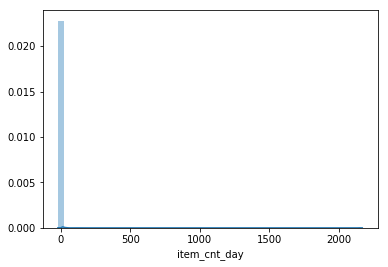

In [15]:
plotData = data[(data.set == 'train')]['item_cnt_day']
sns.distplot(plotData)

Clip values of item_cnt_day to [0, 20] to remove outliers

In [16]:
data['item_cnt_day_before'] = data['item_cnt_day'] # keep for record
data['item_cnt_day'] = data['item_cnt_day_before'].clip(0, 20)

Check item_price

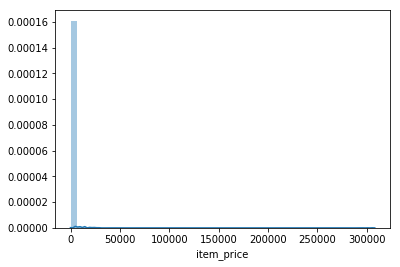

In [17]:
plotData = data[(data.set == 'train')]['item_price']
plot = sns.distplot(plotData)

In [18]:
data['item_price'].describe()

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

In [19]:
data[data['item_price'] == -1]

,ID,set,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,month,year,day,weekday,item_cnt_day_before
484683,484683,train,2013-05-15,4,32,2973,-1.0,1.0,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,5,2013,15,2,1.0


Replace the "-1" price with mean price of the item_id

In [20]:
meanPrice = data[data.item_id == 2973]['item_price'].mean()
data.loc[data.index == 484683, 'item_price'] = meanPrice

Check the items that are expensive

In [21]:
expensiveItems = data[data.item_price > np.nanpercentile(data.item_price, 99.8)]
expensiveItems

,ID,set,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,month,year,day,weekday,item_cnt_day_before
2113,2113,train,2013-01-30,0,24,5748,32990.000000,1.0,"Москва ТК ""Буденовский"" (пав.К7)",Photoshop 13 Windows Russian BOX,75,Программы - Для дома и офиса,1,2013,30,2,1.0
176112,176112,train,2013-02-15,1,12,475,25500.000000,1.0,Интернет-магазин ЧС,1С:Бухгалтерия 8 ПРОФ на 5 польз. Поставка для...,73,Программы - 1С:Предприятие 8,2,2013,15,4,1.0
303130,303130,train,2013-03-25,2,12,475,25500.000000,1.0,Интернет-магазин ЧС,1С:Бухгалтерия 8 ПРОФ на 5 польз. Поставка для...,73,Программы - 1С:Предприятие 8,3,2013,25,0,1.0
322740,322740,train,2013-03-15,2,24,5748,32990.000000,1.0,"Москва ТК ""Буденовский"" (пав.К7)",Photoshop 13 Windows Russian BOX,75,Программы - Для дома и офиса,3,2013,15,4,1.0
366717,366717,train,2013-04-03,3,12,476,25500.000000,1.0,Интернет-магазин ЧС,1С:Бухгалтерия 8 ПРОФ на 5 польз. Поставка для...,73,Программы - 1С:Предприятие 8,4,2013,3,2,1.0
366851,366851,train,2013-04-25,3,12,3143,29700.000000,1.0,Интернет-магазин ЧС,ESET NOD32 Smart Security Business Edition new...,75,Программы - Для дома и офиса,4,2013,25,3,1.0
381102,381102,train,2013-04-09,3,22,476,25500.000000,1.0,Москва Магазин С21,1С:Бухгалтерия 8 ПРОФ на 5 польз. Поставка для...,73,Программы - 1С:Предприятие 8,4,2013,9,1,1.0
454782,454782,train,2013-05-30,4,22,14170,24900.000000,1.0,Москва Магазин С21,Лицензия 1С-Битрикс: Управление сайтом - Малый...,75,Программы - Для дома и офиса,5,2013,30,3,1.0
566344,566344,train,2013-06-19,5,12,475,27100.000000,1.0,Интернет-магазин ЧС,1С:Бухгалтерия 8 ПРОФ на 5 польз. Поставка для...,73,Программы - 1С:Предприятие 8,6,2013,19,2,1.0
598988,598988,train,2013-06-03,5,22,475,27100.000000,1.0,Москва Магазин С21,1С:Бухгалтерия 8 ПРОФ на 5 польз. Поставка для...,73,Программы - 1С:Предприятие 8,6,2013,3,0,1.0


The prices appear to be reasonable and are not outliers except item_id 6066, which needs further investigation

In [22]:
expensiveItems.groupby(['item_id'])['item_price'].agg(["mean", "max", "min", "std", "count"])

,mean,max,min,std,count
item_id,,,,,
102,27900.000000,27900.0,27900.00,0.000000,2
475,29200.000000,35300.0,25500.00,3925.332507,18
476,28050.000000,30600.0,25500.00,2944.486373,4
1349,21990.000000,21990.0,21990.00,NaN,1
2410,34713.500000,36990.0,32437.00,3219.457175,2
2411,23990.000000,23990.0,23990.00,NaN,1
3142,28474.500000,30705.0,26244.00,3154.403351,2
3143,29700.000000,29700.0,29700.00,NaN,1
4856,21050.000000,21050.0,21050.00,NaN,1


In [23]:
data[data.item_id == 6066]

,ID,set,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,month,year,day,weekday,item_cnt_day_before
1163158,1163158,train,2013-12-13,11,12,6066,307980.0,1.0,Интернет-магазин ЧС,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса,12,2013,13,4,1.0


Remove the above row since this item_id is not in the test set, and only 1 unit was sold.  

In [24]:
data = data.drop([1163158], axis= 0)

Sort data by date, shop_id, item_category_id, item_id and then reset index

In [25]:
data = data.sort_values(by=['date_block_num', 'shop_id', 'item_category_id', 'item_id'])
data = data.reset_index(drop=True)

Add features for data analysis

In [26]:
data['revenue'] = data['item_cnt_day'] * data['item_price']

In [27]:
data['yymm'] = data['date'].apply(lambda x: x.strftime('%y%m'))

In [28]:
data['shop_item'] = data['shop_id'].map(str) + '_'+ data['item_id'].map(str)

In [29]:
data['priceNoDecimal'] = data['item_price'] % 1 == 0

In [30]:
data['priceEnding'] = round(data['item_price']) % 100

In [62]:
data.to_pickle('../data/data_raw')

### Exploratory Analysis

#### What are the shop_item combinations that are only in one set?  Are there item categories that are only in the test set?

In [32]:
NumShopItemTestOnly = len(set(data[(data['set'] == 'test')]['shop_item'].unique()) - set(data[(data['set'] == 'train')]['shop_item'].unique()))
NumShopItemTrainOnly = len(set(data[(data['set'] == 'train')]['shop_item'].unique()) - set(data[(data['set'] == 'test')]['shop_item'].unique()))

In [33]:
print('item_shop combination in test set only: ', NumShopItemTestOnly)
print('item_shop combination in training set only: ', NumShopItemTrainOnly)
print('item_shop combination in test set only as a % of total test set: {:.2f}'.format((NumShopItemTestOnly/len(sales_test))*100))
print('item_shop combination in training set only as a % of total training set: {:.2f}'.format((NumShopItemTrainOnly/len(sales_train))*100))

item_shop combination in test set only:  102796
item_shop combination in training set only:  312719
item_shop combination in test set only as a % of total test set: 47.99
item_shop combination in training set only as a % of total training set: 10.65


In [34]:
itemCatNotInTrain = len(set(data[(data['set'] == 'test')]['item_category_id'].unique()) - set(data[(data['set'] == 'train')]['item_category_id'].unique()))
print('Number of item categories not in training set: ', itemCatNotInTrain)

itemCatNotInTest = len(set(data[(data['set'] == 'train')]['item_category_id'].unique()) - set(data[(data['set'] == 'test')]['item_category_id'].unique()))
print('Number of item categories not in testing set: ', itemCatNotInTest)

Number of item categories not in training set:  0
Number of item categories not in testing set:  22


#### What are the categories that are not in the testing set?
'Accessories - PSP', 'Game consoles - PSP',
       'Game consoles - PSVita', 'Music - Music video',
       'Pure carriers (spire)', 'Pure carriers (piece)',
       'Gifts - Postcards, stickers', 'Books - Business Literature',
       'Games - PS2', 'Gifts - Certificates, Services', 'Accessories - PS2',
       'Books - Computer Literature', 'Game Consoles - PS2',
       'Books - Guides', 'Payment cards (Movies, Music, Games)',
       'Cinema - Blu-Ray 4K', 'Books - Fiction',
       'Game consoles - Other', 'Tickets (Number)',
       'Books - Cognitive Literature', 'Books - Postcards',
       'Official - Tickets'
<br>
<br>
Upon revewing the categories, it might make sense to add additional grouping to the product categories based on KNN n-gram on text
       
   

In [35]:
plt.rcParams['figure.figsize'] = (15, 6)

#### What is the revenue trend over the entire timeseries?

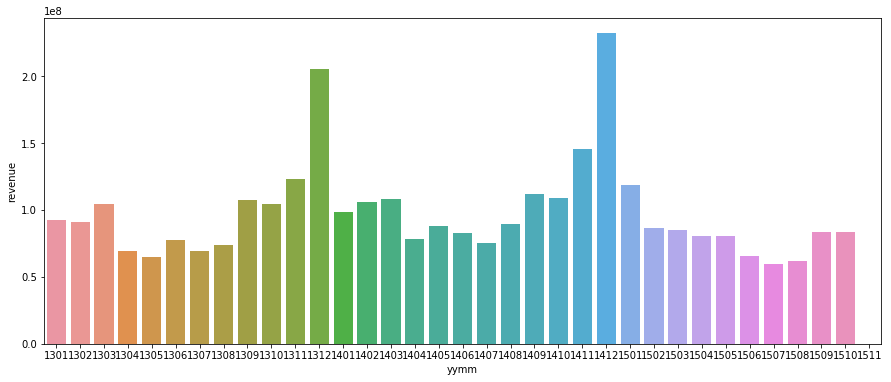

In [36]:
plotdata = data.groupby('yymm')['revenue'].sum()
plotdata = pd.DataFrame(plotdata)
plotdata.reset_index(level=0, inplace=True)

sns.barplot(x="yymm", y="revenue", data= plotdata)

#### What is revenue trend by month of the year.  Is there a seasonality trend?
Revenue peaks torwards end of the year and is lower in mid-year.  2015 revenue is lower then 2013 and 2014.  The model will need to capture the slow down in sales, perhaps by adding a total revenue change from prior period, or moving average of total revenue.  

In [37]:
plotdata = data.groupby(['year','month'])['revenue'].sum()
plotdata = pd.DataFrame(plotdata)
plotdata.reset_index(inplace=True)
cast_dtype(plotdata, ['year','month'], object);

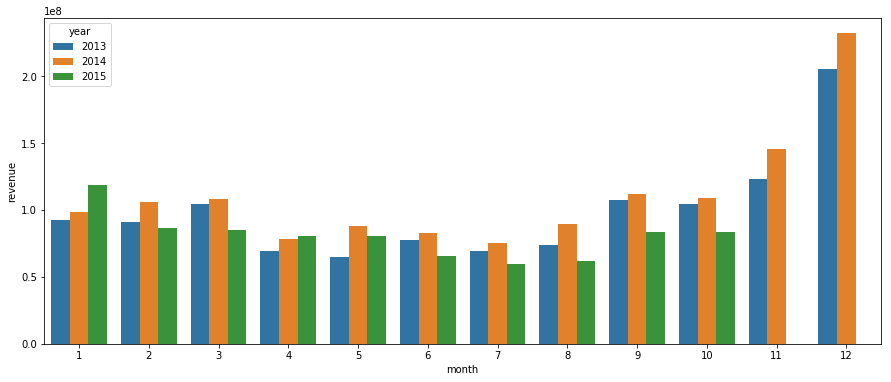

In [38]:
sns.barplot(x='month', y='revenue', hue='year', data=plotdata)

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


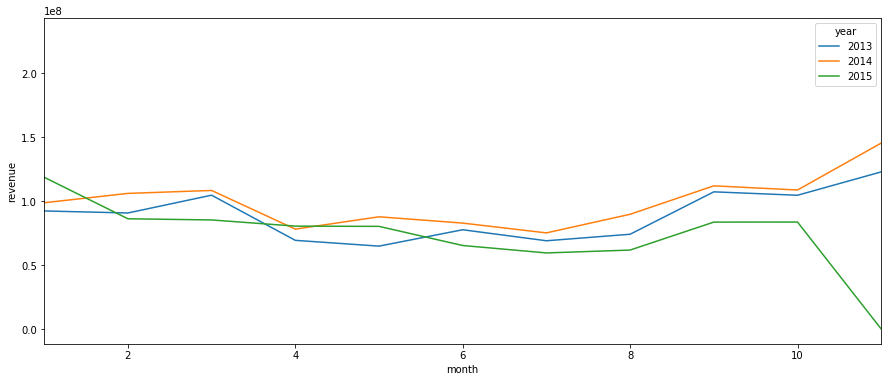

In [39]:
sns.tsplot(plotdata, time='month', unit='year', condition='year', value='revenue')

#### Does sales vary by days of week? 
Sales is highest on the weekends.  Saturday being the highest, followed by Friday and then Sunday. Features that might be helpful to capture the effect might be a count of each of the weekday in the date_block, and count of weekends.  

In [40]:
plotdata = data.groupby(['weekday'])['revenue'].sum()
plotdata = pd.DataFrame(plotdata)
plotdata.reset_index(inplace=True)

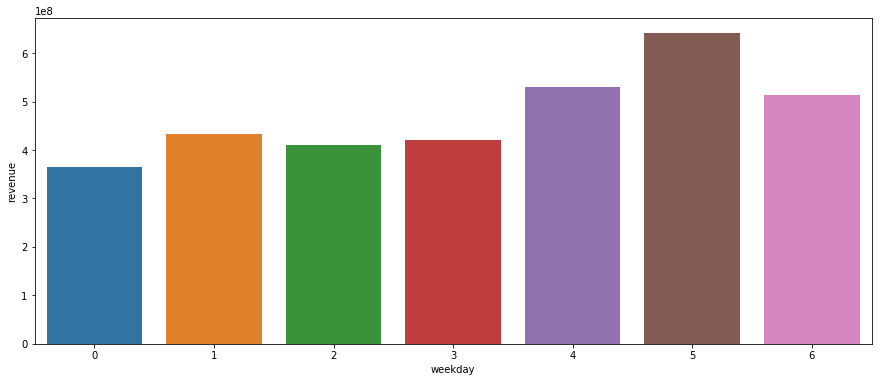

In [41]:
sns.barplot(x='weekday', y='revenue', data=plotdata)
#  Monday=0, Sunday=6

#### What is revenue generated from each item_category_id?
The revenue from the categories varies.  The categories which generated the most revenue were from (19) Games - PS3 
(20) Games - PS4 
(12) Game consoles - PS4
(23) Games - XBOX 360 
(30) PC games - Standard editions

In [42]:
plotdata = data.groupby(['item_category_id'])['revenue'].sum()
plotdata = pd.DataFrame(plotdata)
plotdata.reset_index(inplace=True)
plotdata.nlargest(5, 'revenue').merge(item_cats, how = 'left', on = 'item_category_id')

,item_category_id,revenue,item_category_name
0,19,4.027723e+08,Игры - PS3
1,20,3.533649e+08,Игры - PS4
2,12,2.749915e+08,Игровые консоли - PS4
3,23,2.578328e+08,Игры - XBOX 360
4,30,2.464179e+08,Игры PC - Стандартные издания


In [43]:
cast_dtype(plotdata, ['item_category_id'], object);

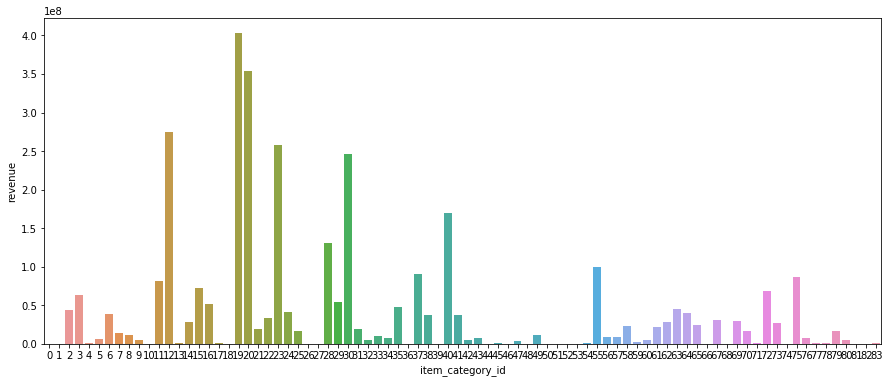

In [44]:
plot = sns.barplot(x='item_category_id', y='revenue', data=plotdata)

#### How much revenue does each shop_id generate?
The revenue varies.  The biggest sales possibly resides from stores in shopping centers according to the shop_name.  The names also contain Moscow.  It should be worthwhile to translate the shop_name into English for further interpretation.

In [45]:
plotdata = data.groupby(['shop_id'])['revenue'].sum()
plotdata = pd.DataFrame(plotdata)
plotdata.reset_index(inplace=True)
plotdata.nlargest(5, 'revenue').merge(shops, how = 'left', on = 'shop_id')

,shop_id,revenue,shop_name
0,31,2.285372e+08,"Москва ТЦ ""Семеновский"""
1,25,2.087222e+08,"Москва ТРК ""Атриум"""
2,28,1.587645e+08,"Москва ТЦ ""МЕГА Теплый Стан"" II"
3,42,1.431199e+08,"СПб ТК ""Невский Центр"""
4,54,1.407470e+08,"Химки ТЦ ""Мега"""


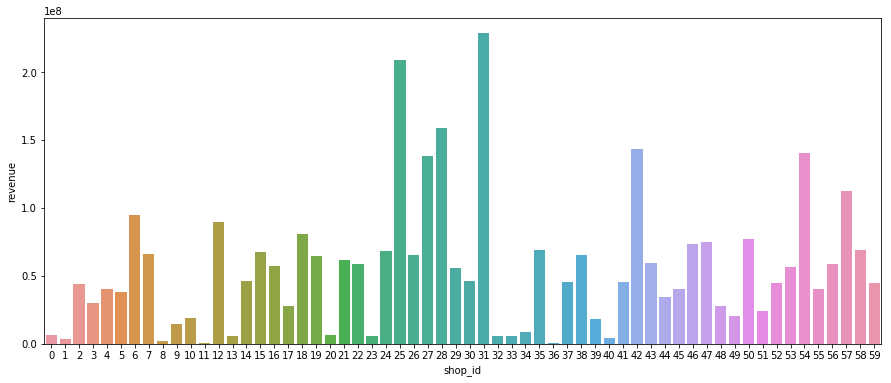

In [46]:
plot = sns.barplot(x='shop_id', y='revenue', data=plotdata)

#### What are the most popular item according to revenue & quantity sold?

#### The highest revenue generating products:
'Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1108A/B01)',
'Grand Theft Auto V [PS3, русские субтитры]',
       'Комплект Sony PS4 (500 Gb) Black (CUH-1108A/B01) + игра Grand Theft Auto V',
       'Grand Theft Auto V [Xbox 360, русские субтитры]',
       'Одни из нас [PS3, русская версия]

In [47]:
plotdata = data.groupby(['item_id'])['revenue'].sum()
plotdata = pd.DataFrame(plotdata)
plotdata.reset_index(inplace=True)
plotdata.nlargest(5, 'revenue').merge(items, how = 'left', on = 'item_id')

,item_id,revenue,item_name,item_category_id
0,6675,2.018860e+08,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,12
1,3732,3.561987e+07,"Grand Theft Auto V [PS3, русские субтитры]",19
2,13443,3.438623e+07,Комплект Sony PS4 (500 Gb) Black (CUH-1108A/B0...,12
3,3734,2.847967e+07,"Grand Theft Auto V [Xbox 360, русские субтитры]",23
4,16787,2.062747e+07,"Одни из нас [PS3, русская версия]",19


#### The most popular items:
'Branded T-shirt 1C Interest White (34 * 42) 45 μm',
'Receiving cash for 1C-Online',
'Playstation Store replenishment of wallet: Payment card 1000 rubles.',
'Diablo III [PC, Jewel, Russian version]',
'Grand Theft Auto V [PS3, Russian subtitles]'

In [48]:
plotdata = data.groupby(['item_id'])['item_cnt_day'].sum()
plotdata = pd.DataFrame(plotdata)
plotdata.reset_index(inplace=True)
plotdata.nlargest(5, 'item_cnt_day').merge(items, how = 'left', on = 'item_id')

,item_id,item_cnt_day,item_name,item_category_id
0,20949,165339.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71
1,17717,15829.0,Прием денежных средств для 1С-Онлайн,79
2,5822,14522.0,Playstation Store пополнение бумажника: Карта ...,35
3,2808,14402.0,"Diablo III [PC, Jewel, русская версия]",30
4,3732,13482.0,"Grand Theft Auto V [PS3, русские субтитры]",19


#### What is the sales trend of the most popular items?
The sales trend varies.  However, for launch of new games  (see 3732 for the plot below), the sale of initial month is high, and then slows down dramatically.  It will be helpful to add feature to indicate first month of sale of a new game.

In [49]:
plotdata = data[data.item_id.isin([20949, 17717, 5822, 2808, 3732])]
plotdata = plotdata.groupby(['item_id', 'date_block_num'])['item_cnt_day'].sum().rename("total").reset_index()
plotdata.head()

,item_id,date_block_num,total
0,2808,0,849.0
1,2808,1,541.0
2,2808,2,486.0
3,2808,3,509.0
4,2808,4,704.0


C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


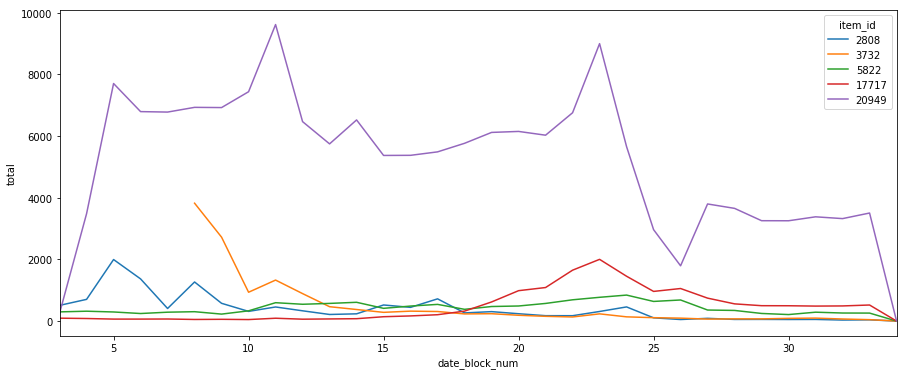

In [50]:
sns.tsplot(plotdata, time='date_block_num', unit='item_id', condition='item_id', value='total')

#### How many items are in each item_category? What are the categories with the most number of products?
Movies - DVD, Music - CD of local production, Movies - Blu-Ray, PC Games - The figure, Music - Vinyl

In [51]:
plotdata = data.groupby(['item_category_id'])['item_id'].nunique()
plotdata = pd.DataFrame(plotdata)
plotdata.reset_index(inplace=True)
plotdata.columns = ['item_category_id', 'item_id_count']
plotdata.nlargest(5, 'item_id_count').merge(item_cats, how = 'left', on = 'item_category_id')


,item_category_id,item_id_count,item_category_name
0,40,5035,Кино - DVD
1,55,2365,Музыка - CD локального производства
2,37,1780,Кино - Blu-Ray
3,31,1125,Игры PC - Цифра
4,58,790,Музыка - Винил


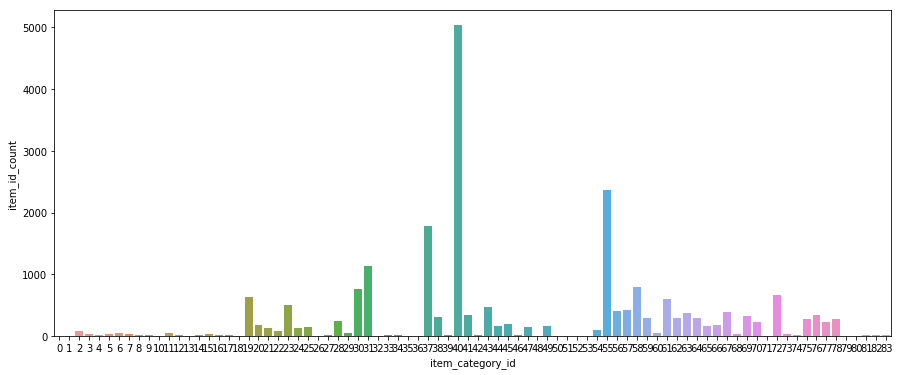

In [52]:
plot = sns.barplot(x='item_category_id', y='item_id_count', data=plotdata)

#### Does the breakdown of revenue by category change over time?
The breakdown of revenue by category actually varies a lot month to month

In [53]:
plotdata = data.groupby(['date_block_num', 'item_category_id'])['revenue'].sum().rename("totalRevenue").reset_index()
plotdata['revenueM'] = plotdata.groupby(['date_block_num'])['totalRevenue'].transform(sum)
plotdata['percentRevenue'] = plotdata['totalRevenue']/plotdata['revenueM'] * 100

In [54]:
plotdata.head()

,date_block_num,item_category_id,totalRevenue,revenueM,percentRevenue
0,0,0,148.00,92352362.72,0.000160
1,0,1,148.00,92352362.72,0.000160
2,0,2,2864399.69,92352362.72,3.101599
3,0,3,209658.90,92352362.72,0.227021
4,0,4,235677.00,92352362.72,0.255193


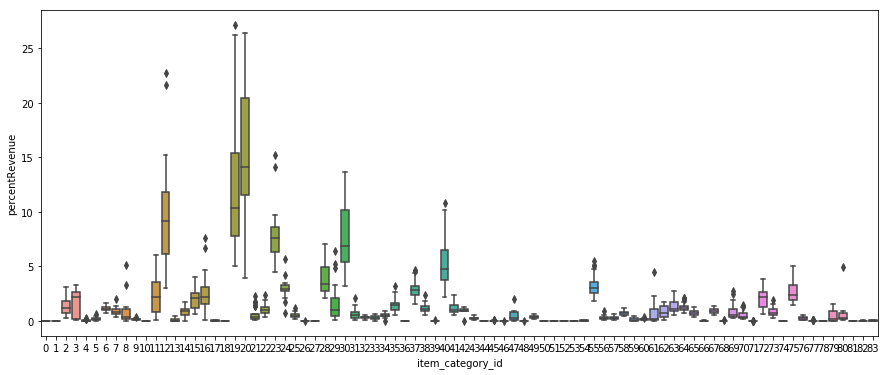

In [55]:
sns.boxplot(x="item_category_id", y="percentRevenue", data=plotdata);

In [56]:
plotdata = data.groupby(['date_block_num', 'item_category_id'])['revenue'].sum().rename("totalRevenue").reset_index()
plotdata['revenueM'] = plotdata.groupby(['date_block_num'])['totalRevenue'].transform(sum)
plotdata['percentRevenue'] = plotdata['totalRevenue']/plotdata['revenueM'] * 100
plotdata = plotdata[plotdata['item_category_id'].isin([19, 20, 12, 23, 30])]
plotdata.head()

,date_block_num,item_category_id,totalRevenue,revenueM,percentRevenue
13,0,19,1.416248e+07,9.235236e+07,15.335265
16,0,23,7.709926e+06,9.235236e+07,8.348379
20,0,30,1.001681e+07,9.235236e+07,10.846292
69,1,19,1.543299e+07,9.076592e+07,17.003068
72,1,23,8.349532e+06,9.076592e+07,9.198973


C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


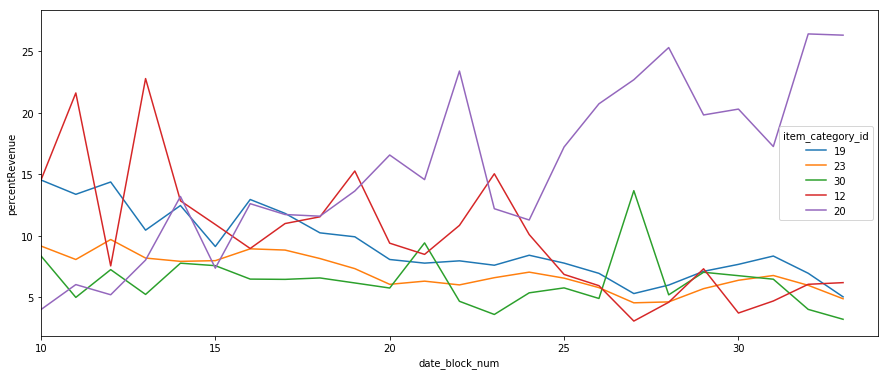

In [57]:
sns.tsplot(time = 'date_block_num', value = 'percentRevenue', unit = 'item_category_id', condition = 'item_category_id', data = plotdata)

#### What are some of the price endings?  Do they have any meaning?
Most products have price ending in 99, followed by 49, 90, and then 0

In [58]:
data['priceNoDecimal'].value_counts()

True     2750939
False     399109
Name: priceNoDecimal, dtype: int64

In [59]:
(data['priceEnding']).value_counts().nlargest(20)

99.0    1687424
49.0     575258
90.0      99418
0.0       78709
98.0      52288
50.0      37056
29.0      31727
5.0       31092
69.0      31054
19.0      24505
79.0      23356
59.0      20449
48.0      12804
39.0      11773
89.0      10447
28.0       9214
58.0       8877
74.0       8760
24.0       6994
70.0       6039
Name: priceEnding, dtype: int64

In [60]:
data[data['item_id'] == 6675]['item_price'].value_counts().nlargest(10)

22990.0    1246
20990.0     619
18990.0     573
18191.0     477
27990.0     372
17991.0     268
24990.0     258
26990.0     234
17990.0     113
19990.0      88
Name: item_price, dtype: int64

In [61]:
data[data['item_id'] == 7982]['item_price'].value_counts().nlargest(10)

15501.0    32
16501.0    27
25990.0    21
25490.0    15
15500.5    13
16092.0    12
15092.0    12
15301.0     9
17001.0     9
16500.5     8
Name: item_price, dtype: int64